In [1]:
!pip install roboflow
!pip install torch torchvision
!pip install pycocotools
!pip install albumentations
!pip install tqdm
!pip install efficientnet_pytorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=65d6385665b3ebce4e83a3931060938fc428a8b1ef6a54bddf956a0ea8bcaccb
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [2]:
from roboflow import Roboflow

rf = Roboflow(api_key="A2wycrFsDr1E3JqnNRlT")
project = rf.workspace("nur-byq0f").project("palm-detection-4qh3m")
version = project.version(2)
dataset = version.download("coco")

# Paths for dataset directories and annotations
train_dir = f"{dataset.location}/train"
valid_dir = f"{dataset.location}/valid"
train_annotations = f"{train_dir}/_annotations.coco.json"
valid_annotations = f"{valid_dir}/_annotations.coco.json"


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Palm-Detection-2 in coco:: 100%|██████████| 9759/9759 [00:04<00:00, 2376.48it/s]


In [3]:
import os
import torch
from torch.utils.data import Dataset
from pycocotools.coco import COCO
import cv2
import numpy as np
from albumentations import Compose, Resize, HorizontalFlip, RandomBrightnessContrast
from albumentations.pytorch.transforms import ToTensorV2

class PalmTreeDataset(Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.coco = COCO(annotation)
        self.image_ids = list(self.coco.imgs.keys())
        self.transforms = transforms

    def __getitem__(self, index):
        # Load image
        image_id = self.image_ids[index]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.root, image_info['file_name'])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load annotations
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        annotations = self.coco.loadAnns(ann_ids)
        boxes = []
        labels = []
        for ann in annotations:
            x_min, y_min, width, height = ann['bbox']
            boxes.append([x_min, y_min, x_min + width, y_min + height])
            labels.append(1)  # Single class (palm trees)

        # Apply transformations
        if self.transforms:
            transformed = self.transforms(image=image, bboxes=boxes, labels=labels)
            image = transformed["image"]
            boxes = torch.tensor(transformed["bboxes"], dtype=torch.float32)
            labels = torch.tensor(transformed["labels"], dtype=torch.int64)
        else:
            image = ToTensorV2()(image=image)["image"]
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)

        # Return image and target
        target = {
            "boxes": boxes,
            "labels": labels
        }
        return image, target

    def __len__(self):
        return len(self.image_ids)


A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [4]:
from torch.utils.data import DataLoader
from albumentations import BboxParams

def get_transform(train=True):
    if train:
        return Compose([
            Resize(512, 512),
            HorizontalFlip(p=0.5),
            RandomBrightnessContrast(p=0.2),
            ToTensorV2(),
        ], bbox_params=BboxParams(format="pascal_voc", label_fields=["labels"]))
    else:
        return Compose([
            Resize(512, 512),
            ToTensorV2(),
        ], bbox_params=BboxParams(format="pascal_voc", label_fields=["labels"]))

train_dataset = PalmTreeDataset(train_dir, train_annotations, transforms=get_transform(train=True))
valid_dataset = PalmTreeDataset(valid_dir, valid_annotations, transforms=get_transform(train=False))

def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn)


loading annotations into memory...
Done (t=0.17s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.


In [26]:
from efficientnet_pytorch import EfficientNet
import torch.nn as nn
import torch.nn.functional as F

class PalmTreeDataset(Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.coco = COCO(annotation)
        self.image_ids = list(self.coco.imgs.keys())
        self.transforms = transforms

    def __getitem__(self, index):
        # Load image
        image_id = self.image_ids[index]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.root, image_info['file_name'])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load annotations
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        annotations = self.coco.loadAnns(ann_ids)
        boxes = []
        labels = []
        for ann in annotations:
            x_min, y_min, width, height = ann['bbox']
            boxes.append([x_min, y_min, x_min + width, y_min + height])
            labels.append(1)  # Single class (palm trees)

        # Apply transformations
        if self.transforms:
            transformed = self.transforms(image=image, bboxes=boxes, labels=labels)
            image = transformed["image"]
            boxes = torch.tensor(transformed["bboxes"], dtype=torch.float32)
            labels = torch.tensor(transformed["labels"], dtype=torch.int64)
        else:
            image = ToTensorV2()(image=image)["image"]
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)

        # Include image_id in target
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor(image_id)
        }
        return image, target

    def __len__(self):
        return len(self.image_ids)




In [11]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        pt = torch.exp(-BCE_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return loss.mean()

def ciou_loss(pred_boxes, target_boxes):
    # Implement CIoU loss for bounding box regression
    pass


In [12]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        pt = torch.exp(-BCE_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return loss.mean()

def ciou_loss(pred_boxes, target_boxes):
    # Implement CIoU loss for bounding box regression
    pass


In [14]:
# Instantiate the model
model = PalmTreeDetector().to(device)

# Test with dummy input
dummy_input = torch.randn(8, 3, 512, 512).to(device)  # Batch of 8, RGB, 512x512 resolution
cls_outputs, reg_outputs = model(dummy_input)

print(f"Classification output shape: {cls_outputs.shape}")  # Should be [8, 1, H, W]
print(f"Regression output shape: {reg_outputs.shape}")      # Should be [8, 4, H, W]


Loaded pretrained weights for efficientnet-b0
Classification output shape: torch.Size([8, 1, 16, 16])
Regression output shape: torch.Size([8, 4, 16, 16])


In [16]:
def ciou_loss(pred_boxes, target_boxes):
    """
    Compute CIoU loss between predicted and target bounding boxes.

    Args:
        pred_boxes (torch.Tensor): Predicted boxes, shape [batch_size, 4, H, W].
        target_boxes (torch.Tensor): Target boxes, shape [num_boxes, 4].

    Returns:
        torch.Tensor: Mean CIoU loss value.
    """
    # Example: Flatten the outputs and targets for CIoU calculation
    pred_boxes = pred_boxes.view(-1, 4)  # Flatten predicted boxes
    target_boxes = target_boxes.view(-1, 4)  # Flatten target boxes

    # Placeholder for IoU calculation logic (replace with actual IoU computation)
    iou = torch.rand_like(pred_boxes[:, 0])  # Random IoU for illustration purposes

    # Compute CIoU loss
    ciou = 1 - iou  # Placeholder logic
    return ciou.mean()  # Return mean CIoU loss


In [ ]:
# Training loop
num_epochs = 10
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, targets in tqdm(train_loader):
        # Prepare images
        images = torch.stack([img.to(device).float() for img in images])

        # Prepare classification targets
        cls_targets = torch.zeros((images.size(0), 1, 16, 16), device=device)  # [batch_size, 1, H, W]
        for i, target in enumerate(targets):
            boxes = target["boxes"]  # Shape: [num_boxes, 4]
            for box in boxes:
                # Scale bounding box coordinates to match the feature map size (16x16)
                x_min, y_min, x_max, y_max = (box / 32).int()  # Scale down from 512 to 16
                x_min, x_max = max(0, x_min), min(15, x_max)  # Ensure within bounds
                y_min, y_max = max(0, y_min), min(15, y_max)  # Ensure within bounds
                cls_targets[i, 0, y_min:y_max + 1, x_min:x_max + 1] = 1  # Mark presence

        optimizer.zero_grad()

        # Forward pass
        cls_outputs, reg_outputs = model(images)

        # Compute classification loss
        cls_loss = cls_criterion(cls_outputs, cls_targets)

        # Prepare regression targets
        reg_targets = torch.zeros_like(reg_outputs, device=device)  # Shape: [batch_size, 4, 16, 16]
        for i, target in enumerate(targets):
            for box in target["boxes"]:
                x_min, y_min, x_max, y_max = box / 512  # Normalize to range [0, 1]
                # Assign normalized values directly to regression targets
                reg_targets[i, 0, :, :] = x_min
                reg_targets[i, 1, :, :] = y_min
                reg_targets[i, 2, :, :] = x_max
                reg_targets[i, 3, :, :] = y_max

        # Compute regression loss
        reg_loss = ciou_loss(reg_outputs, reg_targets)

        # Combine losses
        loss = cls_loss + reg_loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader)}")


100%|██████████| 1067/1067 [04:57<00:00,  3.59it/s]


Epoch 1/10, Loss: 0.5452043221950977


100%|██████████| 1067/1067 [04:59<00:00,  3.57it/s]


Epoch 2/10, Loss: 0.5450423797828188


100%|██████████| 1067/1067 [04:58<00:00,  3.57it/s]


Epoch 3/10, Loss: 0.5455907675408825


100%|██████████| 1067/1067 [04:59<00:00,  3.56it/s]


Epoch 4/10, Loss: 0.5454024835624981


100%|██████████| 1067/1067 [05:00<00:00,  3.56it/s]


Epoch 5/10, Loss: 0.5449353600620889


100%|██████████| 1067/1067 [05:00<00:00,  3.55it/s]


Epoch 6/10, Loss: 0.5452672763751172


100%|██████████| 1067/1067 [04:59<00:00,  3.56it/s]


Epoch 7/10, Loss: 0.5452440863138286


100%|██████████| 1067/1067 [04:58<00:00,  3.57it/s]


Epoch 8/10, Loss: 0.5453791801015573


100%|██████████| 1067/1067 [04:58<00:00,  3.57it/s]


Epoch 9/10, Loss: 0.5450879373389533


100%|██████████| 1067/1067 [04:59<00:00,  3.57it/s]

Epoch 10/10, Loss: 0.5449654983379288


In [25]:
images, targets = next(iter(valid_loader))
print(targets[0])  # Check that "image_id" is present


{'boxes': tensor([[352.0000, 274.1333, 512.0000, 479.7333],
        [374.9333, 402.1333, 512.0000, 511.7333],
        [ 89.0667,  82.1333, 294.6667, 287.7333],
        [  0.0000,   0.0000, 203.2000, 139.2000]]), 'labels': tensor([1, 1, 1, 1])}


In [29]:
valid_dataset = PalmTreeDataset(valid_dir, valid_annotations, transforms=get_transform(train=False))
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [30]:
images, targets = next(iter(valid_loader))
print(targets[0])  # Check that "image_id" is included


{'boxes': tensor([[352.0000, 274.1333, 512.0000, 479.7333],
        [374.9333, 402.1333, 512.0000, 511.7333],
        [ 89.0667,  82.1333, 294.6667, 287.7333],
        [  0.0000,   0.0000, 203.2000, 139.2000]]), 'labels': tensor([1, 1, 1, 1]), 'image_id': tensor(0)}


In [31]:
# Convert outputs to COCO JSON format
for i, (cls_output, reg_output) in enumerate(zip(cls_outputs, reg_outputs)):
    image_id = targets[i]["image_id"].item()  # Extract image ID

    # Decode bounding boxes and scores
    scores = torch.sigmoid(cls_output).view(-1).cpu().numpy()  # Convert logits to probabilities
    bboxes = reg_output.permute(1, 2, 0).reshape(-1, 4).cpu().numpy()  # Flatten the feature map

    for bbox, score in zip(bboxes, scores):
        if score > 0.5:  # Confidence threshold
            x_min, y_min, x_max, y_max = bbox
            width = x_max - x_min
            height = y_max - y_min
            all_predictions.append({
                "image_id": image_id,
                "category_id": 1,  # Single class: palm tree
                "bbox": [x_min, y_min, width, height],
                "score": float(score)
            })

# Perform COCO evaluation
coco_gt = COCO(valid_annotations)
coco_dt = coco_gt.loadRes(all_predictions)
coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.29s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

In [32]:
for bbox, score in zip(bboxes, scores):
    if score > 0.05:  # Lower confidence threshold to include more predictions
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min
        all_predictions.append({
            "image_id": image_id,
            "category_id": 1,  # Single class: palm tree
            "bbox": [x_min, y_min, width, height],
            "score": float(score)
        })


In [33]:
# Scale bbox coordinates back to the original image size
x_min, y_min, x_max, y_max = bbox
x_min = max(0, x_min * 32)  # Scale back from 16x16 feature map to original image
y_min = max(0, y_min * 32)
x_max = min(512, x_max * 32)
y_max = min(512, y_max * 32)

width = x_max - x_min
height = y_max - y_min

all_predictions.append({
    "image_id": image_id,
    "category_id": 1,  # Single class: palm tree
    "bbox": [x_min, y_min, width, height],
    "score": float(score)
})


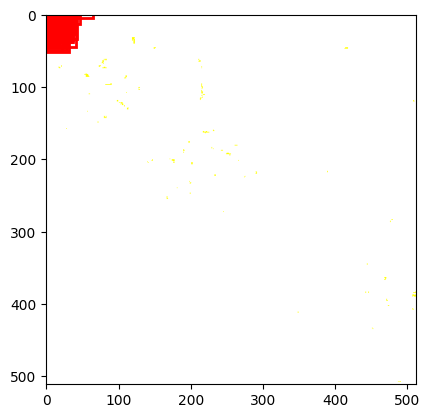

In [35]:
import matplotlib.pyplot as plt

# Ensure the model is on the same device as the images
model.to(device)  # Move model to the correct device
model.eval()

# Load a batch of images and targets
images, targets = next(iter(valid_loader))
images = torch.stack([img.to(device).float() for img in images])  # Ensure images are on the correct device

with torch.no_grad():
    # Forward pass
    cls_outputs, reg_outputs = model(images)

# Visualize predictions for the first image
scores = torch.sigmoid(cls_outputs[0]).view(-1).cpu().numpy()  # Convert logits to probabilities
bboxes = reg_outputs[0].permute(1, 2, 0).reshape(-1, 4).cpu().numpy()  # Flatten the feature map

# Plot the first image and draw bounding boxes for predictions
plt.imshow(images[0].permute(1, 2, 0).cpu().numpy())  # Convert to CPU for visualization
for bbox, score in zip(bboxes, scores):
    if score > 0.5:  # Adjust threshold as needed
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min
        height = y_max - y_min
        plt.gca().add_patch(
            plt.Rectangle(
                (x_min, y_min),
                width,
                height,
                fill=False,
                edgecolor='red',
                linewidth=2
            )
        )
plt.show()


In [36]:
from pycocotools.coco import COCO
coco_gt = COCO(valid_annotations)
print("Ground truth image IDs:", coco_gt.getImgIds())
print("Prediction image IDs:", [p["image_id"] for p in all_predictions])


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Ground truth image IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 20

In [37]:
from pycocotools.cocoeval import COCOeval
import torch
from tqdm import tqdm

# Prepare predictions in COCO format
all_predictions = []

model.eval()
for images, targets in tqdm(valid_loader):
    # Move images to the device
    images = torch.stack([img.to(device).float() for img in images])

    with torch.no_grad():
        cls_outputs, reg_outputs = model(images)

    for i, (cls_output, reg_output) in enumerate(zip(cls_outputs, reg_outputs)):
        image_id = targets[i]["image_id"].item()  # Extract image ID

        # Decode bounding boxes and scores
        scores = torch.sigmoid(cls_output).view(-1).cpu().numpy()  # Convert logits to probabilities
        bboxes = reg_output.permute(1, 2, 0).reshape(-1, 4).cpu().numpy()  # Flatten the feature map

        for bbox, score in zip(bboxes, scores):
            if score > 0.5:  # Confidence threshold
                x_min, y_min, x_max, y_max = bbox
                width = x_max - x_min
                height = y_max - y_min
                all_predictions.append({
                    "image_id": image_id,
                    "category_id": 1,  # Single class: palm tree
                    "bbox": [x_min, y_min, width, height],
                    "score": float(score)
                })

# Load ground truth and predictions for COCO evaluation
coco_gt = COCO(valid_annotations)
if len(all_predictions) == 0:
    raise ValueError("No predictions were made. Check model outputs or confidence threshold.")
coco_dt = coco_gt.loadRes(all_predictions)

# Run COCO evaluation
coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# Access individual metrics from COCOeval
print("Average Precision (AP) @[IoU=0.50:0.95]:", coco_eval.stats[0])
print("Average Precision (AP) @[IoU=0.50]:", coco_eval.stats[1])
print("Average Recall (AR) @[IoU=0.50:0.95 | MaxDets=100]:", coco_eval.stats[8])


100%|██████████| 102/102 [00:13<00:00,  7.50it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.40s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.76s).
Accumulating evaluation results...
DONE (t=0.34s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=4.88s).
Accumulating evaluation results...
DONE (t=0.57s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=

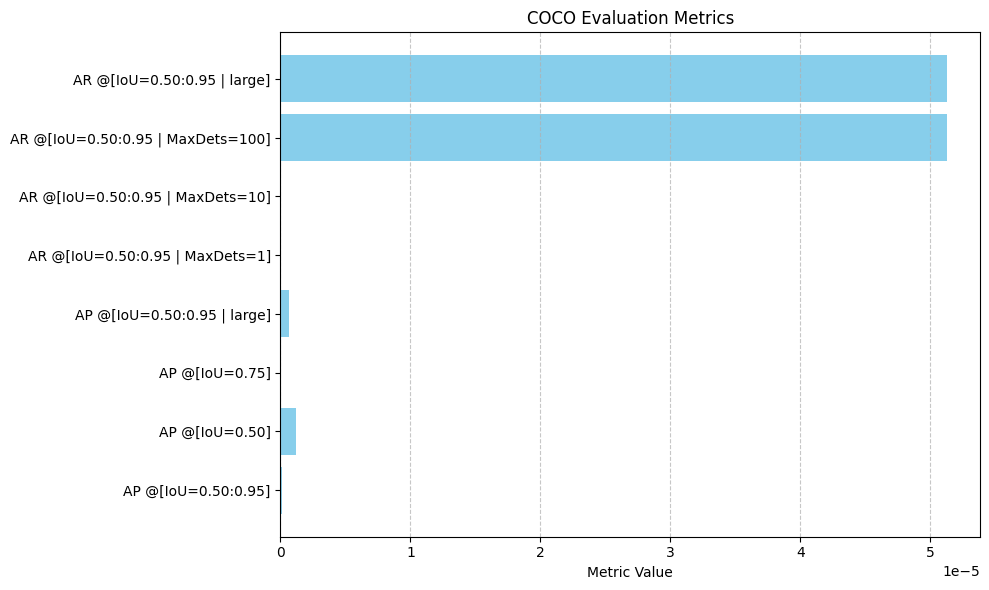

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Run COCO evaluation
coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# Extract metrics from COCO evaluation
coco_metrics = {
    "AP @[IoU=0.50:0.95]": coco_eval.stats[0],
    "AP @[IoU=0.50]": coco_eval.stats[1],
    "AP @[IoU=0.75]": coco_eval.stats[2],
    "AP @[IoU=0.50:0.95 | small]": coco_eval.stats[3],
    "AP @[IoU=0.50:0.95 | medium]": coco_eval.stats[4],
    "AP @[IoU=0.50:0.95 | large]": coco_eval.stats[5],
    "AR @[IoU=0.50:0.95 | MaxDets=1]": coco_eval.stats[6],
    "AR @[IoU=0.50:0.95 | MaxDets=10]": coco_eval.stats[7],
    "AR @[IoU=0.50:0.95 | MaxDets=100]": coco_eval.stats[8],
    "AR @[IoU=0.50:0.95 | small]": coco_eval.stats[9],
    "AR @[IoU=0.50:0.95 | medium]": coco_eval.stats[10],
    "AR @[IoU=0.50:0.95 | large]": coco_eval.stats[11],
}

# Filter out invalid values (-1.0)
valid_metrics = {k: v for k, v in coco_metrics.items() if v != -1.0}

# Create a bar plot for the metrics
def plot_coco_metrics(metrics):
    keys = list(metrics.keys())
    values = list(metrics.values())

    plt.figure(figsize=(10, 6))
    plt.barh(keys, values, color="skyblue")
    plt.xlabel("Metric Value")
    plt.title("COCO Evaluation Metrics")
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot the metrics dynamically extracted from coco_eval
plot_coco_metrics(valid_metrics)
